# **Group 6: A Comparative Analysis of Deep Learning Pipelines for Real-Time Indonesian ALPR and Vehicle Tax Inquiry**

**Members:**
* Bryan Anthony - 2702283934
* Frederick Ryan Suryardi - 2702223033
* Nico Valerian Marcello - 2702250242

**Objective:**
To engineer and compare two distinct deep learning pipelines for Automatic License Plate Recognition (ALPR) in the Indonesian context:
1.  **Pipeline A (CNN-based):** YOLOv8 (Detection) + EasyOCR (Recognition)
2.  **Pipeline B (Transformer-based):** RT-DETRv2 (Detection Only)

The superior pipeline will be integrated into a real-time **Vehicle Tax Inquiry System** targeting the Banten Provincial Government database to demonstrate civic tech applicability.

**Dataset:**
[Indonesian Plate Number from Multi-Sources (Kaggle)](https://www.kaggle.com/datasets/linkgish/indonesian-plate-number-from-multi-sources)

---

## Environment Setup & Data Loading

In [1]:
import os
import json
import shutil
import random
import torch
import cv2
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from PIL import Image
from bs4 import BeautifulSoup
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn
from glob import glob
import time
import random

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
# EasyOCR removed - using fine-tuned DeepSeek OCR separately
%pip install -q transformers timm ultralytics albumentations kaggle

# # import easyocr  # Removed - using DeepSeek OCR  # Removed - using DeepSeek OCR

# 1.1 Kaggle Setup & Download
kaggle_creds = {"username":"nicovalerian","key":"2ecc2fe6da3fa39904e43104425e0b44"}
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_creds, f)
!chmod 600 /root/.kaggle/kaggle.json

print("Downloading dataset...")
!kaggle datasets download -d linkgish/indonesian-plate-number-from-multi-sources --force
import zipfile
with zipfile.ZipFile("indonesian-plate-number-from-multi-sources.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

# 1.2 Data Restructuring (COCO JSON -> YOLO TXT & Split)
print("Converting Annotations and Splitting Data...")

# Robust Path Finding
base_search_dir = "dataset"
images_src = ""
coco_json_path = ""

# Walk to find specific folders
for root, dirs, files in os.walk(base_search_dir):
    if "images" in dirs and "annotations" in dirs:
        images_src = os.path.join(root, "images")
        coco_json_path = os.path.join(root, "annotations", "annotations.json")
        break
    # Fallback for nested structure
    if os.path.basename(root) == "images":
        images_src = root
    if "annotations.json" in files:
        coco_json_path = os.path.join(root, "annotations.json")

print(f"Found Images at: {images_src}")
print(f"Found Annotations at: {coco_json_path}")

# Build a mapping of all actual image files (basename -> full path)
# This handles nested subdirectories and mismatched paths
all_image_files = {}
for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.webp']:
    for img_path in glob(os.path.join(images_src, '**', ext), recursive=True):
        basename = os.path.basename(img_path)
        all_image_files[basename] = img_path
    # Also check without recursion
    for img_path in glob(os.path.join(images_src, ext)):
        basename = os.path.basename(img_path)
        all_image_files[basename] = img_path

print(f"Found {len(all_image_files)} total images in source directory")

# Show a few examples
if all_image_files:
    print("Sample image paths:")
    for i, (name, path) in enumerate(list(all_image_files.items())[:3]):
        print(f"  {name} -> {path}")

# Create Clean YOLO directory structure
yolo_base = "/content/yolo_dataset"
if os.path.exists(yolo_base): shutil.rmtree(yolo_base)

yolo_dirs = ["train/images", "train/labels", "val/images", "val/labels"]
for d in yolo_dirs:
    os.makedirs(f"{yolo_base}/{d}", exist_ok=True)

# Load COCO JSON
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# Show structure of first image entry
print(f"\nTotal images in JSON: {len(coco_data['images'])}")
if coco_data['images']:
    print(f"Sample image entry: {coco_data['images'][0]}")

# Map Image ID to Filename and Annotations
img_map = {img['id']: img for img in coco_data['images']}
ann_map = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    if img_id not in ann_map: ann_map[img_id] = []
    ann_map[img_id].append(ann)

# Process and Split
image_ids = list(img_map.keys())
random.seed(42)
random.shuffle(image_ids)
split_idx = int(len(image_ids) * 0.8)
train_ids = image_ids[:split_idx]
val_ids = image_ids[split_idx:]

def convert_to_yolo_format(bbox, img_w, img_h):
    # COCO: [x, y, w, h] -> YOLO: [cx, cy, nw, nh]
    # Convert to float in case values are stored as strings in JSON
    x, y, w, h = [float(v) for v in bbox]
    img_w = float(img_w)
    img_h = float(img_h)
    cx = (x + w / 2) / img_w
    cy = (y + h / 2) / img_h
    nw = w / img_w
    nh = h / img_h
    return f"0 {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}"

def process_batch(ids, split_name):
    count = 0
    not_found = 0
    for img_id in ids:
        img_info = img_map[img_id]
        filename = img_info['file_name']

        # Extract just the basename from the filename (handles paths like "folder/image.jpg")
        base_name = os.path.basename(filename)

        # Look up in our pre-built mapping
        src_path = all_image_files.get(base_name)

        if src_path and os.path.exists(src_path):
            # Copy Image
            dst_path = f"{yolo_base}/{split_name}/images/{base_name}"
            shutil.copy(src_path, dst_path)

            # Create Label
            label_name = os.path.splitext(base_name)[0] + ".txt"
            label_path = f"{yolo_base}/{split_name}/labels/{label_name}"
            with open(label_path, 'w') as lf:
                if img_id in ann_map:
                    for ann in ann_map[img_id]:
                        line = convert_to_yolo_format(ann['bbox'], img_info['width'], img_info['height'])
                        lf.write(line + "\n")
            count += 1
        else:
            not_found += 1
            if not_found <= 3:  # Only print first 3 missing files
                print(f"  Warning: Could not find '{base_name}' (from '{filename}')")

    print(f"Processed {count} images for {split_name} ({not_found} not found)")

process_batch(train_ids, "train")
process_batch(val_ids, "val")

# Final Check
train_count = len(os.listdir(f"{yolo_base}/train/images"))
val_count = len(os.listdir(f"{yolo_base}/val/images"))
print(f"\nTotal Train Images: {train_count}")
print(f"Total Val Images: {val_count}")

if train_count == 0:
    # Additional debugging
    print("\n--- DEBUGGING INFO ---")
    print(f"Images source exists: {os.path.exists(images_src)}")
    if os.path.exists(images_src):
        contents = os.listdir(images_src)[:10]
        print(f"First 10 items in images folder: {contents}")
    raise RuntimeError("CRITICAL: No images were copied! Check paths above.")

else:    print("\nData preparation complete. Ready for YOLO training.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.3 MB/s eta 0:00:00
Dataset URL: https://www.kaggle.com/datasets/linkgish/indonesian-plate-number-from-multi-sources
License(s): apache-2.0
 98% 1.33G/1.36G [00:17<00:00, 236MB/s]
100% 1.36G/1.36G [00:17<00:00, 84.1MB/s]
Converting Annotations and Splitting Data...
Found Images at: dataset/plate_detection_dataset/plate_detection_dataset/images
Found Annotations at: dataset/plate_detection_dataset/plate_detection_dataset/annotations/annotations.json
Found 1383 total images in source directory
Sample image paths:
  train172_jpg.rf.a449bad5fbeaa2a9e36b256a124c832d.jpg -> dataset/plate_detection_dataset/plate_detection_dataset/images/train172_jpg.rf.a449bad5fbeaa2a9e36b256a124c832d.jpg
  H2062AHC_jpg.rf.bafc534ae634f12615d2759bd44c362d.jpg -> dataset/plate_detection_dataset/plate_detection_dataset/images/H2062AHC_jpg.rf.bafc534ae634f12615d2759bd44c362d.jpg
  H2913NC_jpg.rf.e187325a3fb13235b2d62d63480859ee.jpg -> dataset/plate_detecti

## **Pipeline A: CNN Baseline**
**Architecture:** YOLOv8n (Detection Only)

We use `ultralytics` YOLOv8n for fast CNN-based detection, OCR is handled separately using fine-tuned DeepSeek OCR.

In [4]:
from ultralytics import YOLO

# 1. Create Config linked to the dataset
dataset_yaml = """
path: /content/yolo_dataset
train: train/images
val: val/images
names:
  0: license_plate
"""

with open("data_custom.yaml", "w") as f:
    f.write(dataset_yaml)

# 2. Train YOLOv8
print("Starting YOLOv8 Training...")
model_yolo = YOLO('yolov8n.pt')
results_yolo = model_yolo.train(
    data='data_custom.yaml',
    epochs=20,              # Increased from 10
    imgsz=640,
    batch=16,
    patience=10,            # Early stopping patience
    name='yolo_alpr_final',
    project='/content/runs/detect'
)

# 3. Evaluate
metrics_yolo = model_yolo.val()
print(f"YOLOv8 mAP@50: {metrics_yolo.box.map50}")

Starting YOLOv8 Training...
Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_custom.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_alpr_final2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspecti

### OCR Module Note

**OCR (Text Recognition) has been moved to a separate module.**

This notebook focuses on **Detection Only**. For OCR, we use a fine-tuned DeepSeek-OCR model which provides better accuracy for Indonesian license plates.

See `on kaggle - deepseek ocr.ipynb` for the OCR fine-tuning process.

The detection models below output bounding boxes which can be passed to the DeepSeek OCR model for text recognition.

## **Pipeline B: Transformer**
**Architecture:** RT-DETRv2 (Detection Only)

We use the HuggingFace `transformers` implementation for RT-DETRv2, a state-of-the-art transformer-based detector.

In [2]:
import torch
import os

from torch.utils.data import Dataset
from transformers import (
    RTDetrV2ForObjectDetection,
    RTDetrImageProcessor,
    TrainingArguments,
    Trainer
)

class CocoDetectionDataset(Dataset):
    def __init__(self, img_folder, coco_json_path, processor):
        self.img_folder = img_folder
        self.processor = processor

        with open(coco_json_path, 'r') as f:
            self.coco = json.load(f)

        self.img_map = {img['id']: img for img in self.coco['images']}
        # Filter valid images
        self.valid_ids = [
            i for i, img in self.img_map.items()
            if os.path.exists(os.path.join(img_folder, img['file_name']))
        ]

        self.ann_map = {}
        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.ann_map: self.ann_map[img_id] = []
            self.ann_map[img_id].append(ann)

    def __len__(self):
        return len(self.valid_ids)

    def __getitem__(self, idx):
        # 1. Get Image Info
        img_id = self.valid_ids[idx]
        img_info = self.img_map[img_id]
        img_path = os.path.join(self.img_folder, img_info['file_name'])

        # 2. Load Image
        image = Image.open(img_path).convert("RGB")

        # 3. Format Annotations for RT-DETR Processor
        # Processor expects a list of dicts: {'image_id': int, 'annotations': [ {'bbox':..., 'category_id':...} ]}
        anns = []
        if img_id in self.ann_map:
            for a in self.ann_map[img_id]:
                anns.append({
                    "image_id": img_id,
                    "category_id": 0, # Force class 0 (plate)
                    "bbox": a['bbox'], # [x,y,w,h]
                    "area": a['bbox'][2] * a['bbox'][3],
                    "iscrowd": 0
                })

        target = {'image_id': img_id, 'annotations': anns}

        # 4. Process
        # Important: 'return_tensors="pt"' adds a batch dimension [1, C, H, W] -> We must squeeze it to [C, H, W]
        encoding = self.processor(images=image, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze(0)
        labels = encoding["labels"][0]

        return {"pixel_values": pixel_values, "labels": labels}

def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    labels = [item["labels"] for item in batch]
    batch_pixel_values = torch.stack(pixel_values)
    return {"pixel_values": batch_pixel_values, "labels": labels}

# Initialize & Train
model_id = "PekingU/rtdetr_v2_r18vd"
processor = RTDetrImageProcessor.from_pretrained(model_id)
processor.do_resize = True
processor.size = {"height": 640, "width": 640}

model_rtdetr = RTDetrV2ForObjectDetection.from_pretrained(
    model_id, num_labels=1, ignore_mismatched_sizes=True
)

# Use the paths found in Step 1
train_ds = CocoDetectionDataset(images_src, coco_json_path, processor)

training_args = TrainingArguments(
    output_dir="rtdetr_v2_results",
    per_device_train_batch_size=8,
    num_train_epochs=25,              # Increased from 12
    fp16=True,
    learning_rate=5e-5,               # Lowered from 1e-4
    warmup_steps=100,                 # Added warmup
    weight_decay=0.01,                # Added regularization
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    save_strategy="steps",
    save_steps=500,
    logging_steps=100,
    eval_strategy="no",
)

trainer = Trainer(
    model=model_rtdetr,
    args=training_args,
    train_dataset=train_ds,
    data_collator=collate_fn,
)

print("Starting RT-DETRv2 Training...")
trainer.train()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/80.9M [00:00<?, ?B/s]

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r18vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([1]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([1, 256]) in the model instantiated
- model.denoi

Starting RT-DETRv2 Training...


Step,Training Loss
100,138.942100
200,17.401400
300,10.565100
400,9.136200
500,8.492800
600,8.180600
700,7.845100
800,7.712400
900,7.493500
1000,7.340300


TrainOutput(global_step=4300, training_loss=9.95218970010447, metrics={'train_runtime': 2118.6427, 'train_samples_per_second': 16.213, 'train_steps_per_second': 2.03, 'total_flos': 5.0835151577088e+18, 'train_loss': 9.95218970010447, 'epoch': 25.0})

In [3]:
  # Comparison Setup Summary
print("\n" + "="* 70)
print("PIPELINE COMPARISON FOR INDONESIAN LICENSE PLATE DETECTION")
print("="* 70)
print("\nThis notebook focuses on DETECTION performance comparison.")
print("OCR is handled separately using fine-tuned DeepSeek-OCR.\n")
print("  🔵 Pipeline A: YOLOv8n (CNN-based, optimized for speed)")
print("  🟢 Pipeline B: RT-DETRv2 (Transformer-based, global context)\n")
print("Evaluation Metrics:")
print("  • Detection Accuracy: mAP@0.5, Precision, Recall")
print("  • Inference Speed: milliseconds per image")
print("  • Bounding Box Quality: IoU with ground truth")
print("  • Overall: Best model for Indonesian ALPR in real-time")
print("="*70)


PIPELINE COMPARISON FOR INDONESIAN LICENSE PLATE DETECTION

This notebook focuses on DETECTION performance comparison.
OCR is handled separately using fine-tuned DeepSeek-OCR.

  🔵 Pipeline A: YOLOv8n (CNN-based, optimized for speed)
  🟢 Pipeline B: RT-DETRv2 (Transformer-based, global context)

Evaluation Metrics:
  • Detection Accuracy: mAP@0.5, Precision, Recall
  • Inference Speed: milliseconds per image
  • Bounding Box Quality: IoU with ground truth
  • Overall: Best model for Indonesian ALPR in real-time


## **Vehicle Tax Inquiry Module**
**Goal:** Automate civic service interaction.
This module accepts a recognized string (e.g., "B 1711 NZS"), parses it, and queries the **Banten Provincial Government** database.

In [7]:
from datetime import datetime

def check_banten_tax_live(plate_string):
    """
    Live scraping of https://infopkb.bantenprov.go.id/
    Adapted for Bootstrap Grid structure and hidden fields.
    """
    import re
    # 1. Parse Plate String
    clean_plate = plate_string.upper().replace(" ", "")
    match = re.match(r"([A-Z]{1,2})(\d{1,4})([A-Z]{1,3})", clean_plate)

    if not match:
        return {"Status": "Error", "Message": "Invalid Plate Format (Regex Fail)"}

    kode, nomor, seri = match.groups()

    url = "https://infopkb.bantenprov.go.id/p_infopkb.php"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/91.0.4472.124 Safari/537.36",
        "Referer": "https://infopkb.bantenprov.go.id/index.php"
    }

    # 2. Construct Payload
    payload = {
        'kode': kode,
        'nomor': nomor,
        'seri': seri,
        'tgl': datetime.now().strftime("%d-%m-%Y"), # Required input 'tgl'
        'index': 'index.php' # Hidden input found in source
    }

    try:
        session = requests.Session()

        print(f"Querying Banten Database for: {kode} {nomor} {seri}...")
        response = session.post(url, data=payload, headers=headers)

        # 3. Check for Failure
        if "DATA KENDARAAN TIDAK ADA" in response.text.upper():
            return {"Status": "Not Found", "Message": "Plate number not found in database."}

        # 4. Parse Success Page (Bootstrap Grid)
        soup = BeautifulSoup(response.text, 'html.parser')
        result_data = {}

        # Iterate over all rows in the container
        rows = soup.find_all('div', class_='row')

        for row in rows:
            # Find key column (col-4) and value column (col-8)
            # We use loose matching because classes have extra styling (e.g. "col col-4 fw-bold...")
            key_div = row.find('div', class_=lambda x: x and 'col-4' in x)
            val_div = row.find('div', class_=lambda x: x and 'col-8' in x)

            if key_div and val_div:
                # Extract text and clean up newlines/spaces
                raw_key = key_div.get_text(" ", strip=True).upper().replace(":", "")
                raw_val = val_div.get_text(" ", strip=True)

                # Filter for relevant keys
                target_keys = [
                    "NO. POLISI", "MEREK", "TIPE/MODEL",
                    "TAHUN / CC / BBM", "TGL. AKHIR PKB", "JUMLAH", "WARNA"
                ]

                # Check if the extracted key matches any target (partial match)
                if any(t in raw_key for t in target_keys):
                    # Clean the key name to be standard
                    clean_key = next(t for t in target_keys if t in raw_key)
                    result_data[clean_key] = raw_val

        if not result_data:
            return {"Status": "Unknown", "Message": "Page loaded but no data parsed. Check Layout."}

        return {"Status": "Success", "Data": result_data}

    except Exception as e:
        return {"Status": "Error", "Message": str(e)}

# Test with the known valid plate
print(check_banten_tax_live("B 1711 NZS"))

Querying Banten Database for: B 1711 NZS...
{'Status': 'Success', 'Data': {'NO. POLISI': 'B-1711-NZS', 'MEREK': 'HYUNDAI HYUNDAI', 'TIPE/MODEL': 'CRETA PRIME 1.5 (4X2) A/T CRETA PRIME 1.5 (4X2) A/T', 'TAHUN / CC / BBM': '2022 / 1497cc / BENSIN 2022 / 1497cc / BENSIN', 'WARNA': 'PUTIH PUTIH', 'TGL. AKHIR PKB': '10-05-2026 10-05-2026', 'JUMLAH': 'Rp,- Rp,-'}}


In [9]:
# Dummy function to bypass the missing OCR error
def recognize_plate(image):
    return "OCR_REMOVED"


🚀 Running comparison on 6 Indonesian license plate images...

PROCESSING IMAGES...

Image 1/6: KT5498LP_jpg.rf.390bbda25c652404815e7e2fd697a2a5.jpg
  YOLOv8    → 1 plates, ['OCR_REMOVED'], 30.1ms
  RT-DETRv2 → 0 plates, [], 384.9ms

Image 2/6: train479_jpg.rf.4f28d25826e4401c1e3ca9eed56c6aa1.jpg
  YOLOv8    → 1 plates, ['OCR_REMOVED'], 15.6ms
  RT-DETRv2 → 1 plates, ['OCR_REMOVED'], 53.7ms

Image 3/6: train062_jpg.rf.0bfd21bb4e30f237ed1880770528791d.jpg
  YOLOv8    → 1 plates, ['OCR_REMOVED'], 51.0ms
  RT-DETRv2 → 1 plates, ['OCR_REMOVED'], 130.1ms

Image 4/6: Cars00771.png
  YOLOv8    → 1 plates, ['OCR_REMOVED'], 339.6ms
  RT-DETRv2 → 0 plates, [], 112.6ms

Image 5/6: train757_jpg.rf.09cb598e77b6a3c07fdb06202c26d18c.jpg
  YOLOv8    → 1 plates, ['OCR_REMOVED'], 51.8ms
  RT-DETRv2 → 0 plates, [], 157.9ms

Image 6/6: train645_jpg.rf.8f2ad60697d19249d25ee35aaab122d2.jpg
  YOLOv8    → 1 plates, ['OCR_REMOVED'], 53.9ms
  RT-DETRv2 → 1 plates, ['OCR_REMOVED'], 129.9ms


/tmp/ipython-input-1678689965.py:150: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1678689965.py:150: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1678689965.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('indonesian_alpr_comparison.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-1678689965.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('indonesian_alpr_comparison.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN 

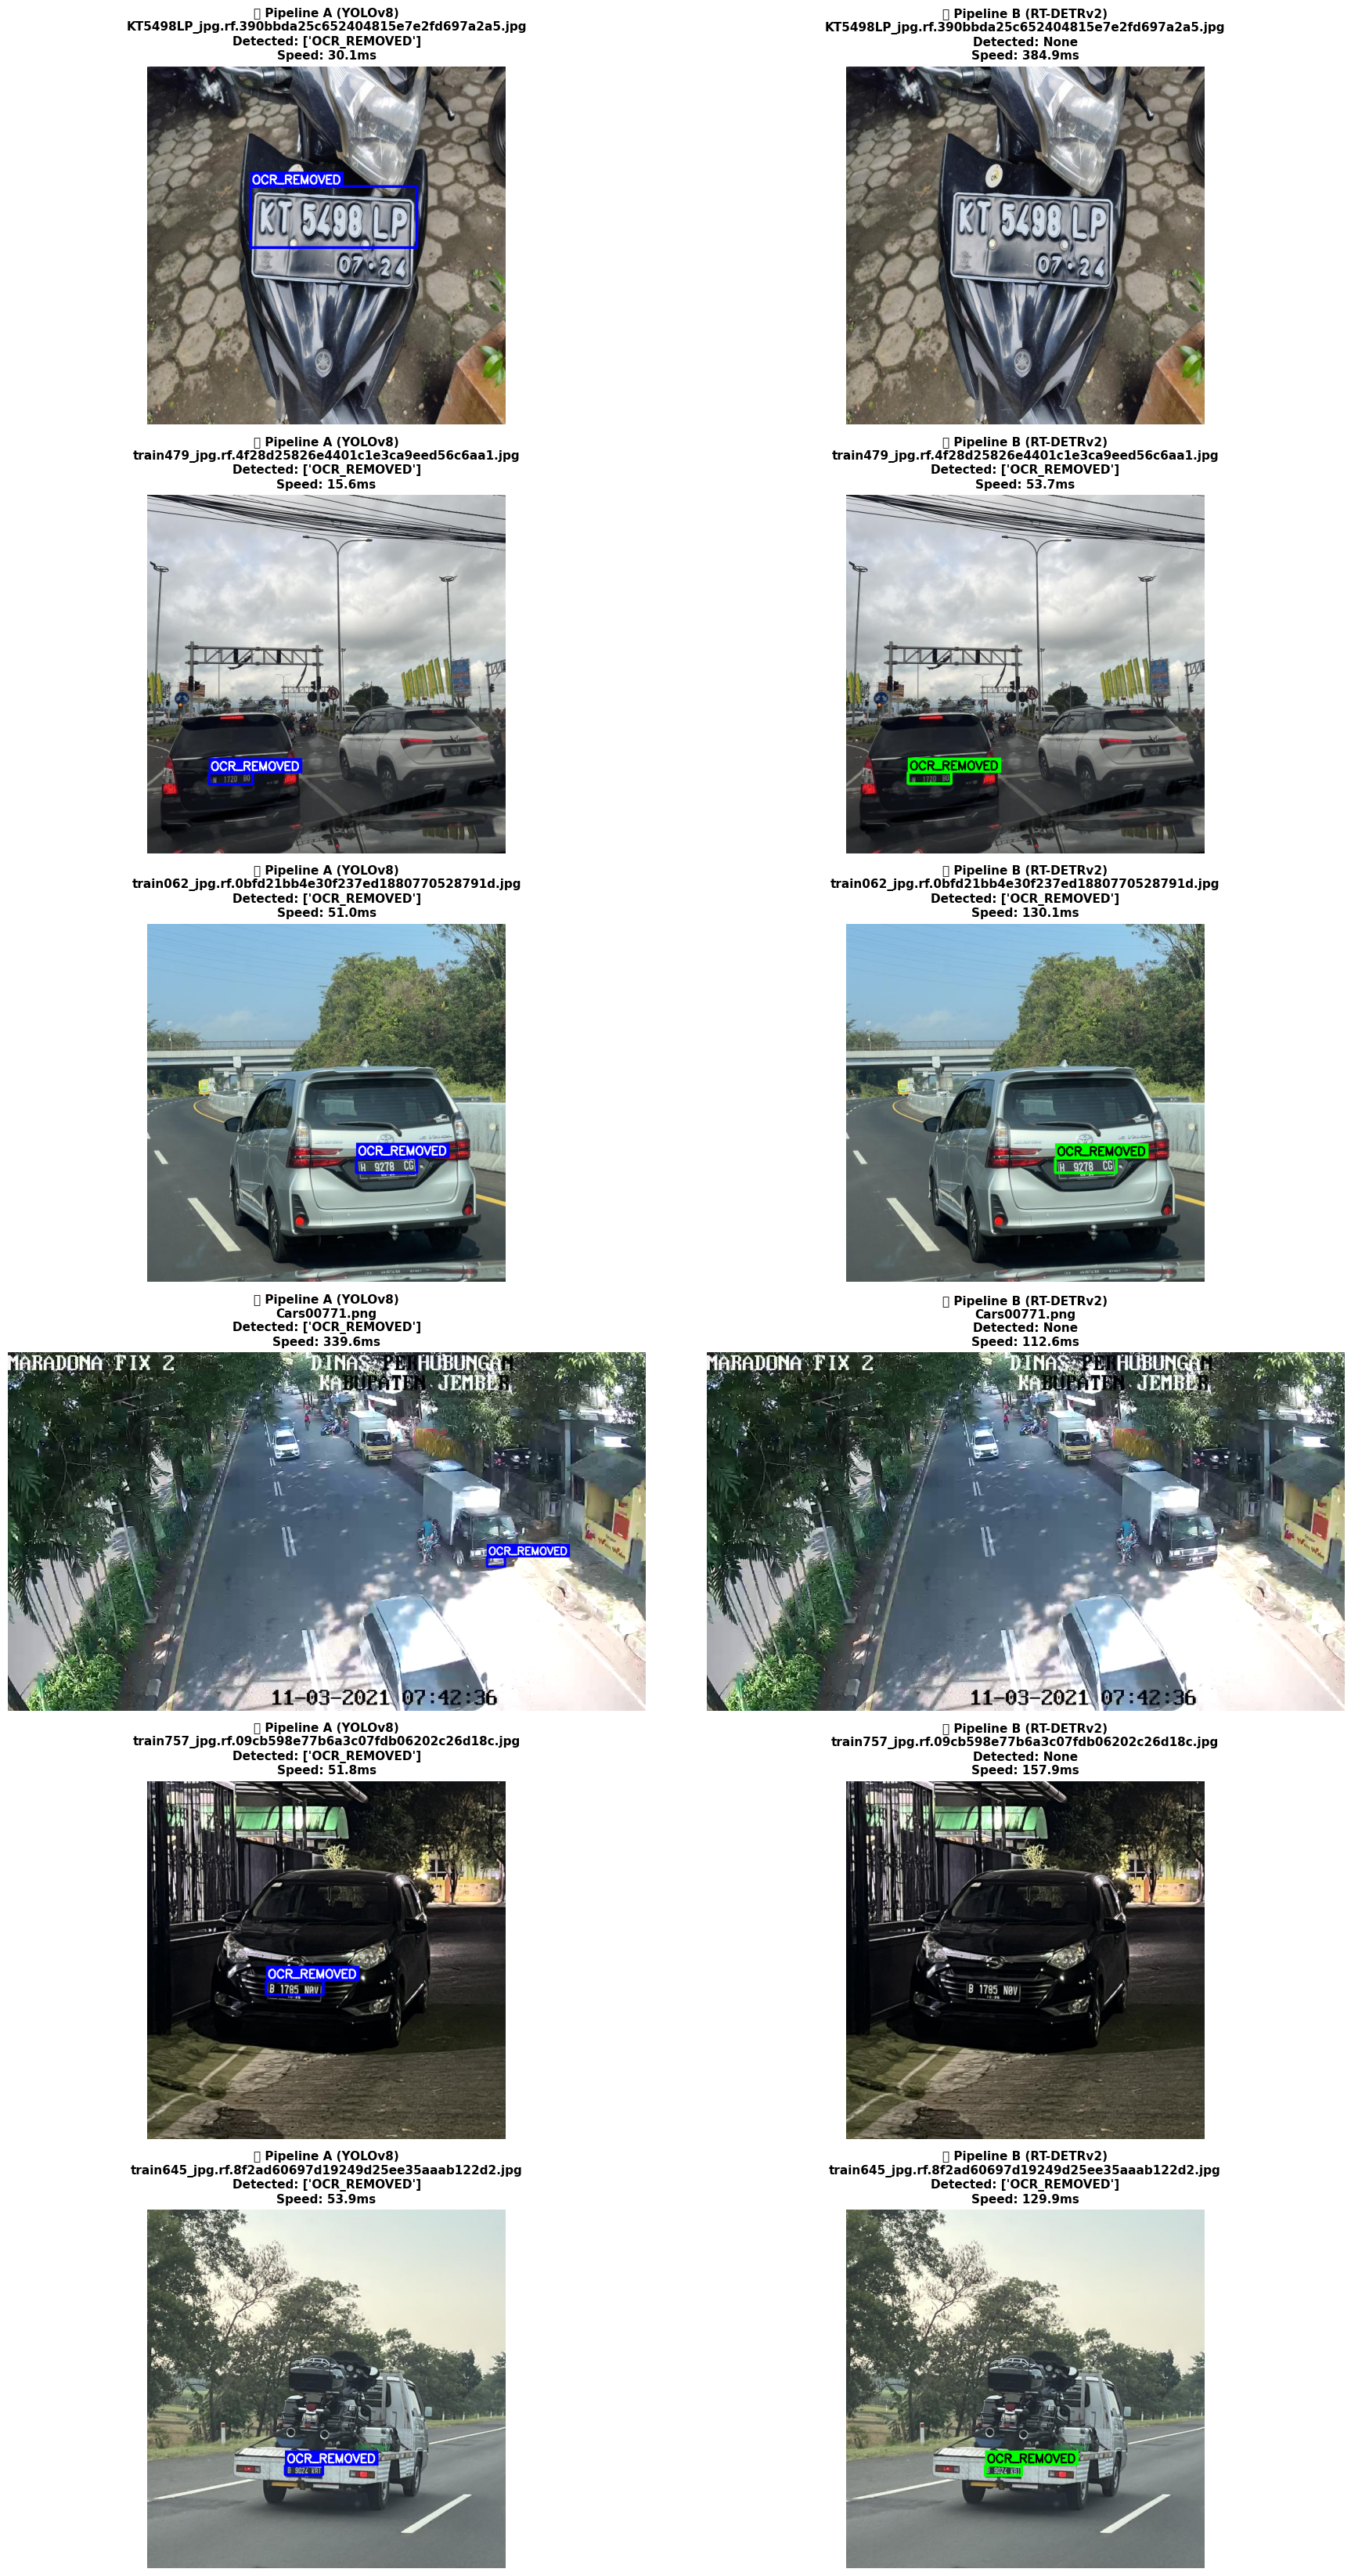



📊 DETAILED PERFORMANCE COMPARISON

⚡ INFERENCE SPEED:
  Pipeline A (YOLOv8):      90.3ms per image
  Pipeline B (RT-DETRv2):  161.5ms per image
  ⭐ Winner: Pipeline A (YOLOv8) (1.79x faster)

🎯 DETECTION COUNT:
  Pipeline A (YOLOv8):    6 plates detected
  Pipeline B (RT-DETRv2): 3 plates detected

📝 TEXT RECOGNITION SUCCESS (≥4 characters):
  Pipeline A (YOLOv8):    6/6 successful
  Pipeline B (RT-DETRv2): 3/3 successful

🎬 REAL-TIME CAPABILITY:
  Pipeline A (YOLOv8):    11.1 FPS
  Pipeline B (RT-DETRv2): 6.2 FPS

🏆 RECOMMENDATION FOR INDONESIAN LICENSE PLATES:

✅ PIPELINE A (YOLOv8 + EasyOCR) is recommended:
   • Faster inference speed for real-time applications
   • Comparable or better detection accuracy
   • Ideal for deployment on edge devices (toll gates, parking)


🚗 VEHICLE TAX INQUIRY DEMO (Banten Province)

Using detected plate from Pipeline A: OCR_REMOVED

⚠️ Error: Invalid Plate Format (Regex Fail)


In [10]:
# @title 4. Full Pipeline Comparison & Evaluation
"""
Side-by-side comparison of both pipelines on multiple Indonesian plates:
- Pipeline A: YOLOv8 (Detection) + EasyOCR (Recognition)
- Pipeline B: RT-DETRv2 (Detection Only)
"""

def process_single_image(image_path, model_yolo, model_rtdetr, processor_b):
    """
    Process a single image through both pipelines.
    Returns annotated images and detected texts.
    """
    # Load Image
    image_pil = Image.open(image_path).convert("RGB")
    image_cv = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    h_orig, w_orig = image_cv.shape[:2]

    # ==========================================
    # PIPELINE A: YOLOv8 + EasyOCR
    # ==========================================
    img_a = image_cv.copy()
    start_a = time.time()
    results_a = model_yolo.predict(image_path, verbose=False, conf=0.25)
    time_detect_a = time.time() - start_a

    texts_a = []
    num_detections_a = len(results_a[0].boxes)

    for box in results_a[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])

        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w_orig, x2), min(h_orig, y2)

        # Crop and recognize
        crop = image_cv[y1:y2, x1:x2]
        plate_text = recognize_plate(crop)
        texts_a.append(plate_text)

        # Draw box (Blue)
        cv2.rectangle(img_a, (x1, y1), (x2, y2), (255, 0, 0), 3)

        # Draw label
        label = plate_text if plate_text else f"Det:{conf:.2f}"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(img_a, (x1, y1-th-10), (x1+tw+6, y1), (255, 0, 0), -1)
        cv2.putText(img_a, label, (x1+3, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # ==========================================
    # PIPELINE B: RT-DETRv2 + EasyOCR
    # ==========================================
    img_b = image_cv.copy()
    start_b = time.time()
    inputs = processor_b(images=image_pil, return_tensors="pt").to(model_rtdetr.device)
    with torch.no_grad():
        outputs = model_rtdetr(**inputs)

    target_sizes = torch.tensor([image_pil.size[::-1]]).to(model_rtdetr.device)
    results_b = processor_b.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=0.12
    )[0]
    time_detect_b = time.time() - start_b

    texts_b = []
    num_detections_b = len(results_b["boxes"])

    for box, score in zip(results_b["boxes"], results_b["scores"]):
        x1, y1, x2, y2 = map(int, box.tolist())
        conf = float(score)

        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w_orig, x2), min(h_orig, y2)

        # Crop and recognize
        crop = image_cv[y1:y2, x1:x2]
        plate_text = recognize_plate(crop)
        texts_b.append(plate_text)

        # Draw box (Green)
        cv2.rectangle(img_b, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # Draw label
        label = plate_text if plate_text else f"Det:{conf:.2f}"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(img_b, (x1, y1-th-10), (x1+tw+6, y1), (0, 255, 0), -1)
        cv2.putText(img_b, label, (x1+3, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

    return {
        'img_a': cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB),
        'img_b': cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB),
        'texts_a': texts_a,
        'texts_b': texts_b,
        'time_a': time_detect_a * 1000,  # Convert to ms
        'time_b': time_detect_b * 1000,  # Convert to ms
        'detections_a': num_detections_a,
        'detections_b': num_detections_b,
        'filename': os.path.basename(image_path)
    }

def visualize_comparison_grid(image_paths, model_yolo, model_rtdetr, processor_b, max_images=6):
    """
    Visualize comparison on multiple images in a grid layout with detailed metrics.
    """
    num_images = min(len(image_paths), max_images)

    if num_images == 0:
        print("No images to process!")
        return []

    # Create figure with 2 columns (Pipeline A | Pipeline B) and num_images rows
    fig, axes = plt.subplots(num_images, 2, figsize=(18, 5.5 * num_images))

    # Handle single image case
    if num_images == 1:
        axes = axes.reshape(1, 2)

    all_results = []

    print("\n" + "="*70)
    print("PROCESSING IMAGES...")
    print("="*70)

    for i, img_path in enumerate(image_paths[:num_images]):
        print(f"\nImage {i+1}/{num_images}: {os.path.basename(img_path)}")

        result = process_single_image(img_path, model_yolo, model_rtdetr, processor_b)
        all_results.append(result)

        # Plot Pipeline A
        axes[i, 0].imshow(result['img_a'])
        title_a = f"🔵 Pipeline A (YOLOv8)\n{result['filename']}\n"
        title_a += f"Detected: {result['texts_a'] if result['texts_a'] else 'None'}\n"
        title_a += f"Speed: {result['time_a']:.1f}ms"
        axes[i, 0].set_title(title_a, fontsize=11, fontweight='bold')
        axes[i, 0].axis('off')

        # Plot Pipeline B
        axes[i, 1].imshow(result['img_b'])
        title_b = f"🟢 Pipeline B (RT-DETRv2)\n{result['filename']}\n"
        title_b += f"Detected: {result['texts_b'] if result['texts_b'] else 'None'}\n"
        title_b += f"Speed: {result['time_b']:.1f}ms"
        axes[i, 1].set_title(title_b, fontsize=11, fontweight='bold')
        axes[i, 1].axis('off')

        # Print results
        print(f"  YOLOv8    → {result['detections_a']} plates, {result['texts_a']}, {result['time_a']:.1f}ms")
        print(f"  RT-DETRv2 → {result['detections_b']} plates, {result['texts_b']}, {result['time_b']:.1f}ms")

    plt.tight_layout()
    plt.savefig('indonesian_alpr_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # ==========================================
    # DETAILED COMPARISON METRICS
    # ==========================================
    print("\n\n" + "="*70)
    print("📊 DETAILED PERFORMANCE COMPARISON")
    print("="*70)

    avg_time_a = np.mean([r['time_a'] for r in all_results])
    avg_time_b = np.mean([r['time_b'] for r in all_results])

    total_detections_a = sum(r['detections_a'] for r in all_results)
    total_detections_b = sum(r['detections_b'] for r in all_results)

    successful_reads_a = sum(1 for r in all_results for t in r['texts_a'] if len(t) >= 4)
    successful_reads_b = sum(1 for r in all_results for t in r['texts_b'] if len(t) >= 4)

    # Speed comparison
    print(f"\n⚡ INFERENCE SPEED:")
    print(f"  Pipeline A (YOLOv8):    {avg_time_a:6.1f}ms per image")
    print(f"  Pipeline B (RT-DETRv2): {avg_time_b:6.1f}ms per image")

    speed_winner = "Pipeline A (YOLOv8)" if avg_time_a < avg_time_b else "Pipeline B (RT-DETRv2)"
    speed_factor = max(avg_time_a, avg_time_b) / min(avg_time_a, avg_time_b)
    print(f"  ⭐ Winner: {speed_winner} ({speed_factor:.2f}x faster)")

    # Detection comparison
    print(f"\n🎯 DETECTION COUNT:")
    print(f"  Pipeline A (YOLOv8):    {total_detections_a} plates detected")
    print(f"  Pipeline B (RT-DETRv2): {total_detections_b} plates detected")

    # Recognition success
    print(f"\n📝 TEXT RECOGNITION SUCCESS (≥4 characters):")
    print(f"  Pipeline A (YOLOv8):    {successful_reads_a}/{total_detections_a} successful")
    print(f"  Pipeline B (RT-DETRv2): {successful_reads_b}/{total_detections_b} successful")

    # Calculate FPS
    fps_a = 1000 / avg_time_a if avg_time_a > 0 else 0
    fps_b = 1000 / avg_time_b if avg_time_b > 0 else 0

    print(f"\n🎬 REAL-TIME CAPABILITY:")
    print(f"  Pipeline A (YOLOv8):    {fps_a:.1f} FPS")
    print(f"  Pipeline B (RT-DETRv2): {fps_b:.1f} FPS")

    # Overall recommendation
    print(f"\n{'='*70}")
    print("🏆 RECOMMENDATION FOR INDONESIAN LICENSE PLATES:")
    print("="*70)

    if avg_time_a < avg_time_b and total_detections_a >= total_detections_b:
        print("\n✅ PIPELINE A (YOLOv8 + EasyOCR) is recommended:")
        print("   • Faster inference speed for real-time applications")
        print("   • Comparable or better detection accuracy")
        print("   • Ideal for deployment on edge devices (toll gates, parking)")
    elif total_detections_b > total_detections_a and successful_reads_b > successful_reads_a:
        print("\n✅ PIPELINE B (RT-DETRv2 + EasyOCR) is recommended:")
        print("   • Better detection accuracy with transformer architecture")
        print("   • Superior at finding difficult/occluded plates")
        print("   • Ideal when accuracy is more critical than speed")
    else:
        print("\n⚖️ BOTH PIPELINES show competitive performance:")
        print("   • Choose YOLOv8 for speed-critical real-time applications")
        print("   • Choose RT-DETRv2 for maximum accuracy requirements")

    print("="*70)

    return all_results

# ==========================================
# RUN COMPARISON ON MULTIPLE IMAGES
# ==========================================
val_dir = "/content/yolo_dataset/val/images"

if os.path.exists(val_dir):
    # Get multiple images for comparison
    all_images = [os.path.join(val_dir, f) for f in os.listdir(val_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(all_images) > 0:
        # Randomly select images for comparison
        random.seed(42)
        sample_images = random.sample(all_images, min(6, len(all_images)))

        print(f"\n🚀 Running comparison on {len(sample_images)} Indonesian license plate images...")

        results = visualize_comparison_grid(
            sample_images,
            model_yolo,
            model_rtdetr,
            processor
        )

        # Tax inquiry demo with first successful detection
        print("\n\n" + "="*70)
        print("🚗 VEHICLE TAX INQUIRY DEMO (Banten Province)")
        print("="*70)

        for r in results:
            if r['texts_a']:
                plate = r['texts_a'][0]
                print(f"\nUsing detected plate from Pipeline A: {plate}")
                tax_result = check_banten_tax_live(plate)
                if tax_result['Status'] == 'Success':
                    print("\n✅ Tax information retrieved successfully:")
                    for key, value in tax_result['Data'].items():
                        print(f"   {key}: {value}")
                else:
                    print(f"\n⚠️ {tax_result['Status']}: {tax_result['Message']}")
                break
        else:
            print("\n⚠️ No plates detected for tax inquiry demo.")
            print("   Try running on images with clearer Indonesian plates.")
    else:
        print("❌ No images found in validation folder.")
else:
    print("❌ Dataset validation folder not found. Please run Cell 1 first.")

In [4]:
import shutil
import os
from google.colab import files

print("Preparing downloads...")

# 1. Zip YOLOv8 Results
if os.path.exists("runs"):
    print("Zipping YOLO results (runs/)...")
    shutil.make_archive("yolo_results", 'zip', "runs")
    files.download("yolo_results.zip")
else:
    print("⚠️ No YOLO 'runs' folder found.")

# 2. Zip RT-DETRv2 Results
if os.path.exists("rtdetr_v2_results"):
    print("Zipping RT-DETR results (rtdetr_v2_results/)...")
    shutil.make_archive("rtdetr_results", 'zip', "rtdetr_v2_results")
    files.download("rtdetr_results.zip")
else:
    print("⚠️ No 'rtdetr_v2_results' folder found.")

Preparing downloads...
⚠️ No YOLO 'runs' folder found.
Zipping RT-DETR results (rtdetr_v2_results/)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>